In [1]:
import sqlite3, pandas

In [2]:
db = sqlite3.connect('citibike.db')

In [3]:
def query(sql):
    res = pandas.read_sql_query(sql,db,chunksize=100_000)
    return next(res)

In [5]:
res = query("SELECT * from tripdata Limit 5")
res

,index,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,0,330,2018-10-01 00:00:00.7010,2018-10-01 00:05:30.8490,293.0,Lafayette St & E 8 St,40.730207,-73.991026,504.0,1 Ave & E 16 St,40.732219,-73.981656,30493,Subscriber,1995,1
1,1,309,2018-10-01 00:00:13.5780,2018-10-01 00:05:23.2310,433.0,old - E 13 St & Avenue A,40.729554,-73.980572,394.0,E 9 St & Avenue C,40.725213,-73.977688,33054,Subscriber,1967,1
2,2,734,2018-10-01 00:00:16.6040,2018-10-01 00:12:31.5050,3472.0,W 15 St & 10 Ave,40.742754,-74.007474,285.0,Broadway & E 14 St,40.734546,-73.990741,33400,Subscriber,1983,2
3,3,788,2018-10-01 00:00:35.0670,2018-10-01 00:13:43.5780,417.0,Barclay St & Church St,40.712912,-74.010202,3472.0,W 15 St & 10 Ave,40.742754,-74.007474,31140,Customer,1988,1
4,4,1136,2018-10-01 00:00:38.1410,2018-10-01 00:19:34.6490,3699.0,W 50 St & 9 Ave,40.763605,-73.989180,495.0,W 47 St & 10 Ave,40.762699,-73.993012,20294,Subscriber,1969,0


In [6]:
db.execute(
"""
create table 
tripdata_clean as
select
(2018 - "birth year") as age,
case when gender = 0 then 'x'
     when gender = 1 then 'M'
     when gender = 2 then 'F' end as sex,
    *
    from tripdata
    where age> 0
    and age < 80
    and tripduration < 6000

"""
)

In [8]:
query("select  count(*) from tripdata_clean")

,count(*)
0,4138173


In [9]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [10]:
import seaborn

ModuleNotFoundError: No module named 'seaborn'

In [11]:
res = query(
"""
select age, count(*) as c from tripdata_clean group by age
""")

In [12]:
res

,age,c
0,16,3119
1,17,6945
2,18,15831
3,19,24905
4,20,31393
...,...,...
59,75,1832
60,76,2312
61,77,1599
62,78,945


(array([  3119.,   6945.,  15831.,  24905.,  31393.,  38640.,  51860.,
         85969., 111588., 142370., 153443., 157760., 167011., 164515.,
        167415., 146721., 139491., 135997., 129867., 121378., 114623.,
        107130.,  99898.,  91577.,  81776.,  79365.,  79161.,  77590.,
         73697.,  71709.,  72799.,  72127.,  77942., 276283.,  64358.,
         63812.,  60193.,  57572.,  59152.,  54514.,  51709.,  46035.,
         45813.,  38602.,  33948.,  32707.,  28807.,  22105.,  21423.,
         18854.,  12178.,  11086.,   8354.,   6739.,   6864.,   5453.,
          4570.,   2483.,   1915.,   1832.,   2312.,   1599.,    945.,
           344.]),
 array([16.      , 16.984375, 17.96875 , 18.953125, 19.9375  , 20.921875,
        21.90625 , 22.890625, 23.875   , 24.859375, 25.84375 , 26.828125,
        27.8125  , 28.796875, 29.78125 , 30.765625, 31.75    , 32.734375,
        33.71875 , 34.703125, 35.6875  , 36.671875, 37.65625 , 38.640625,
        39.625   , 40.609375, 41.59375 , 42.57

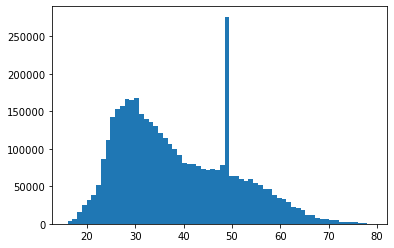

In [13]:
hist(res.age,weights=res.c,bins=len(res))

In [15]:
res = query(
"""
select age,
sum(case when sex='F' then 1 end) as "F",
sum(case when sex='M' then 1 end) as "M"
from 
tripdata_clean group by 1
""")

In [16]:
res.head()

,age,F,M
0,16,793,2302
1,17,1245,5649
2,18,3059,12685
3,19,5797,19053
4,20,7006,24265


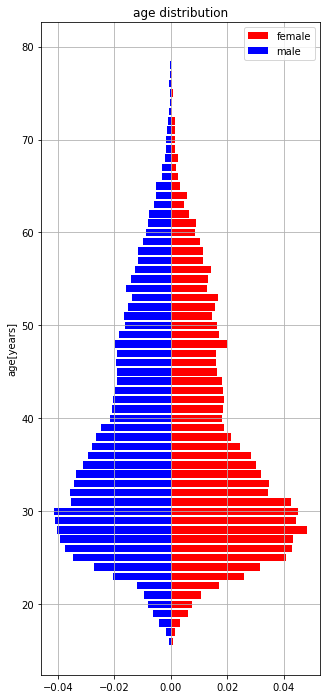

In [17]:
figure(figsize=(5,12))
barh(res.age,res.F/res.F.sum(),color='r',label='female')
barh(res.age,-res.M/res.M.sum(),color='b',label='male')
title('age distribution')
ylabel('age[years]')
grid()
legend()


In [21]:
res = query(
"""
select age,
sum(case when usertype='Subscriber' then 1 end) as "s",
sum(case when usertype !='subscriber' then 1 end) as "d"
from 
tripdata_clean group by 1
""")

In [22]:
res.head

<bound method NDFrame.head of     age      s      d
0    16   2320   3119
1    17   6041   6945
2    18  12860  15831
3    19  21219  24905
4    20  27227  31393
..  ...    ...    ...
59   75   1818   1832
60   76   2308   2312
61   77   1599   1599
62   78    938    945
63   79    343    344

[64 rows x 3 columns]>

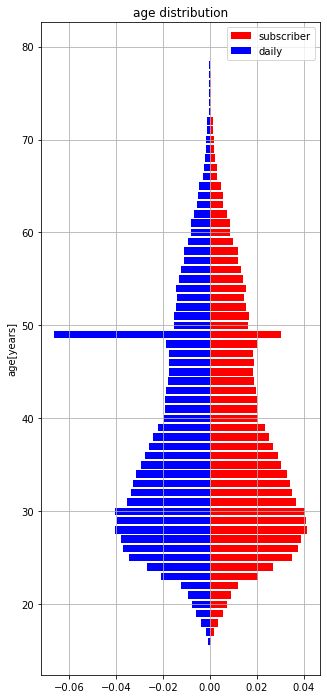

In [23]:
figure(figsize=(5,12))
barh(res.age,res.s/res.s.sum(),color='r',label='subscriber')
barh(res.age,-res.d/res.d.sum(),color='b',label='daily')
title('age distribution')
ylabel('age[years]')
grid()
legend()


In [24]:
res = query(
"""
select tripduration / 60 as 'd',
sum(case when sex='F' then 1 end) as "F",
sum(case when sex='M' then 1 end) as "M"
from 
tripdata_clean group by 1
""")

In [25]:
res.head()

,d,F,M
0,1,11451,62157
1,2,29582,143092
2,3,48133,202443
3,4,60774,232953
4,5,65701,236590


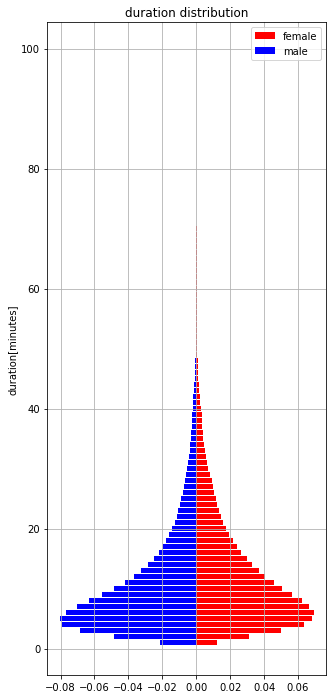

In [27]:
figure(figsize=(5,12))
barh(res.d,res.F/res.F.sum(),color='r',label='female')
barh(res.d,-res.M/res.M.sum(),color='b',label='male')
title('duration distribution')
ylabel('duration[minutes]')
grid()
legend()

In [76]:
res = query(
"""
select 
  "start station name" as name,
  "start station latitude" as lat,
  "start station longitude" as lon,
count(*) as c
from
tripdata_clean group by 1,2,3
""")
res.head()

,name,lat,lon,c
0,None,40.839,-73.878,1
1,None,40.842,-73.887,17
2,None,40.842,-73.881,3
3,None,40.842,-73.878,9
4,None,40.845,-73.914,2


(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  1.,  1.,  2.,  5., 13., 10., 17., 24.,
        24., 16., 27., 15., 16., 17., 12., 10., 12., 13., 15., 19., 24.,
        23., 20., 18., 15., 15., 15., 17., 12., 22., 17., 15., 24., 17.,
        21., 21., 22., 19., 16., 18., 17., 13., 10., 11.,  9., 10., 11.,
        11., 10., 12.,  9.,  7.,  7.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  3.,  6.,  5.,  8.,  8.,  9.,  9.,  8.,  5.,  2.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([40.6  , 40.603, 40.606, 40.609, 40.612, 40.615, 40.618, 40.621,
        40.624, 40.627, 40.63 , 40.633, 40.636, 40.639, 40.642, 40.645,
        40.648, 40.651, 40.654, 40.657, 40.66 , 40.663, 40.666, 40.669,
        40.672, 40.675, 40.678, 40.681, 40.684, 40.687, 40.69 , 40.693,
        40.696, 40.699, 40.702, 40.705, 40.708, 40.711, 40.714, 40.717,
        40.72 , 40.723, 40.726, 40.729, 40.732, 40.735, 40.738, 40.741,
  

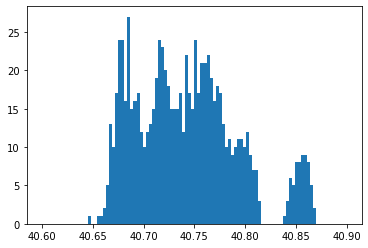

In [77]:
hist(res.lat,range=(40.6,40.9),bins=100)

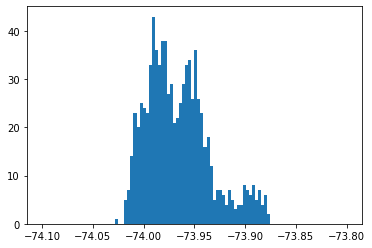

In [78]:
hist(res.lon,range=(-74.1,-73.8),bins=100);

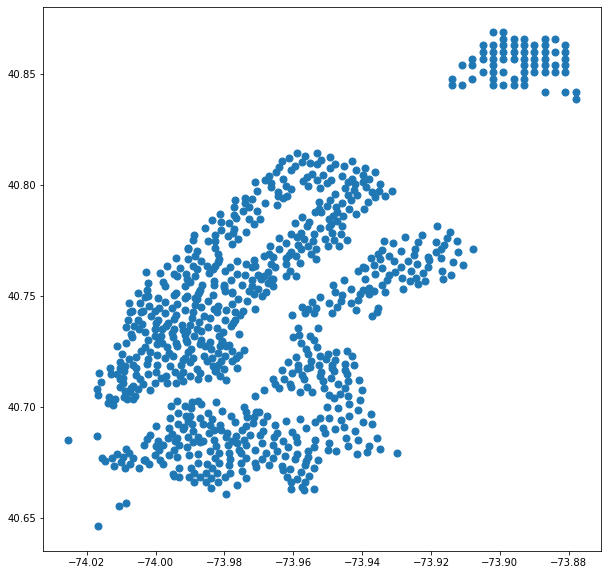

In [79]:
figure(figsize=(10,10))
plot(res.lon,res.lat,'o',ms=7)

(40.645, 40.825)

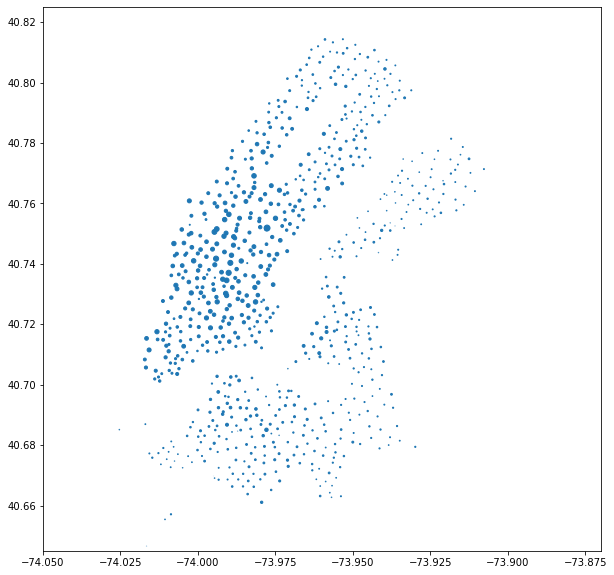

In [80]:
figure(figsize=(10,10))
extent=.18
xstart=-74.05
ystart=40.645
scatter(res.lon,res.lat,35*res.c/res.c.max())
xlim(xstart,xstart+extent)
ylim(ystart,ystart+extent)

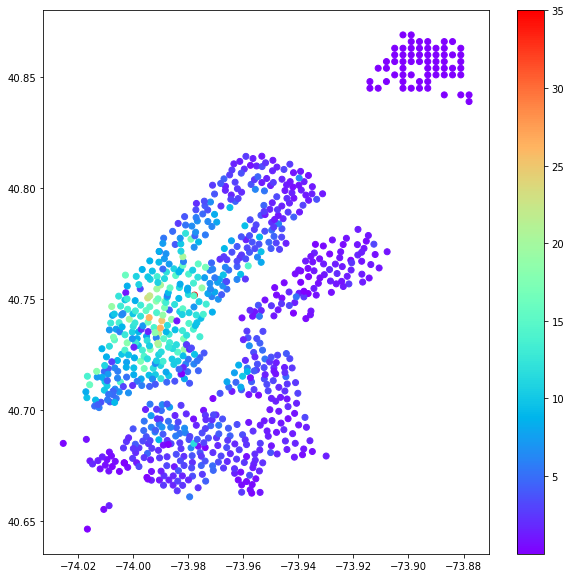

In [81]:
figure(figsize=(10,10))
#extent=.18
#xstart=-74.05
#ystart=40.645
scatter(res.lon,res.lat, c=35*res.c/res.c.max(),cmap='rainbow')
#xlim(xstart,xstart+extent)
#ylim(ystart,ystart+extent)
colorbar()

In [86]:
res.head()

,name,lat,lon,c
0,None,40.839,-73.878,1
1,None,40.842,-73.887,17
2,None,40.842,-73.881,3
3,None,40.842,-73.878,9
4,None,40.845,-73.914,2


In [84]:
def my_plot(x,y,s,c,max_size=50):
    figure(figsize=(10,10))
    #extent=.18
    #xstart=-74.05
    #ystart=40.645
    scatter(res.lon,res.lat, s=max_size*res.c/res.c.max(),cmap='rainbow')
    #xlim(xstart,xstart+extent)
    #ylim(ystart,ystart+extent)
    colorbar()

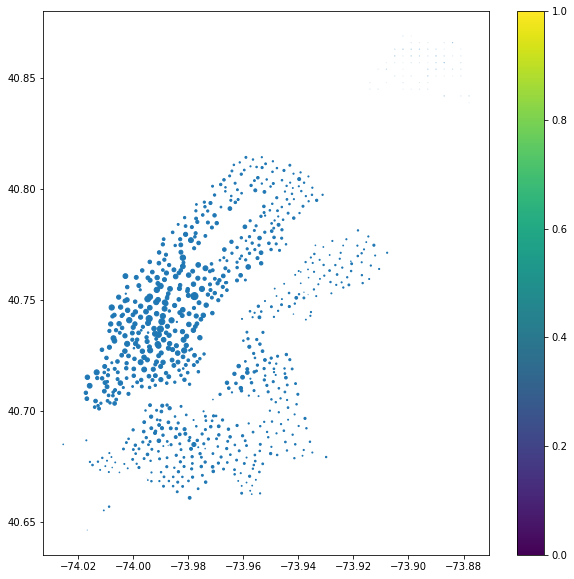

In [85]:
my_plot(res.lat,res.lon,res.c,res.c)

In [95]:
def my_plot(x,y,s,c,max_size=50):
    figure(figsize=(10,10))
    #extent=.18
    #xstart=-74.05
    #ystart=40.645
    scatter(res.lon,res.lat, s=max_size*s/max(s), c=c, cmap='rainbow')
    #xlim(xstart,xstart+extent)
    #ylim(ystart,ystart+extent)
    colorbar()

In [96]:
res = query(
"""
select 
  "start station name",
  "start station latitude" as lat,
  "start station longitude" as lon,
  avg(tripduration) as d,
  sum(case when sex='F' then 1 end) as 'F',
  sum(case when sex='M' then 1 end) as 'M'
from
tripdata_clean group by 1,2,3
""")
res.head(100)

,start station name,lat,lon,d,F,M
0,None,40.839000,-73.878000,695.000000,NaN,1.0
1,None,40.842000,-73.887000,1245.588235,4.0,5.0
2,None,40.842000,-73.881000,898.000000,NaN,2.0
3,None,40.842000,-73.878000,1172.777778,1.0,8.0
4,None,40.845000,-73.914000,765.500000,NaN,2.0
...,...,...,...,...,...,...
95,2 Ave & E 99 St,40.786259,-73.945526,674.711409,393.0,1270.0
96,21 St & 31 Dr,40.765900,-73.930819,698.089763,289.0,946.0
97,21 St & 36 Ave,40.760185,-73.936273,661.971246,54.0,246.0
98,21 St & 38 Ave,40.757631,-73.939122,742.355556,67.0,241.0


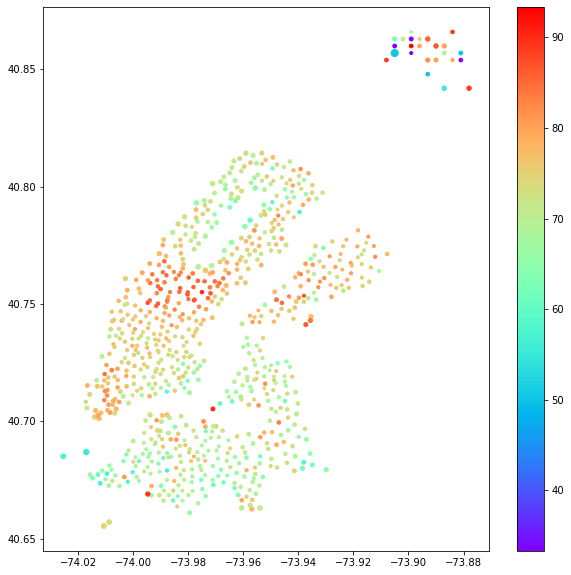

In [97]:
my_plot(res.lon,res.lat,res.d,100*res.M/(res.M+res.F))

In [ ]:
res = query(
"""
select 
  "start station name",
  "start station latitude" as lat,
  "start station longitude" as lon,
  avg(case when sex='F' then age end) as 'F',
  avg(case when sex='M' then age end) as 'M'
from
tripdata_clean group by 1,2,3
""")


In [102]:
res.head(100)

,start station name,lat,lon,d,F,M
0,None,40.839000,-73.878000,695.000000,NaN,1.0
1,None,40.842000,-73.887000,1245.588235,4.0,5.0
2,None,40.842000,-73.881000,898.000000,NaN,2.0
3,None,40.842000,-73.878000,1172.777778,1.0,8.0
4,None,40.845000,-73.914000,765.500000,NaN,2.0
...,...,...,...,...,...,...
95,2 Ave & E 99 St,40.786259,-73.945526,674.711409,393.0,1270.0
96,21 St & 31 Dr,40.765900,-73.930819,698.089763,289.0,946.0
97,21 St & 36 Ave,40.760185,-73.936273,661.971246,54.0,246.0
98,21 St & 38 Ave,40.757631,-73.939122,742.355556,67.0,241.0
